2024-10-26 14:52:17,773 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.
2024-10-26 14:52:17,801 - WARNING - tvb.simulator.integrators - random_state supplied for non-stochastic integration


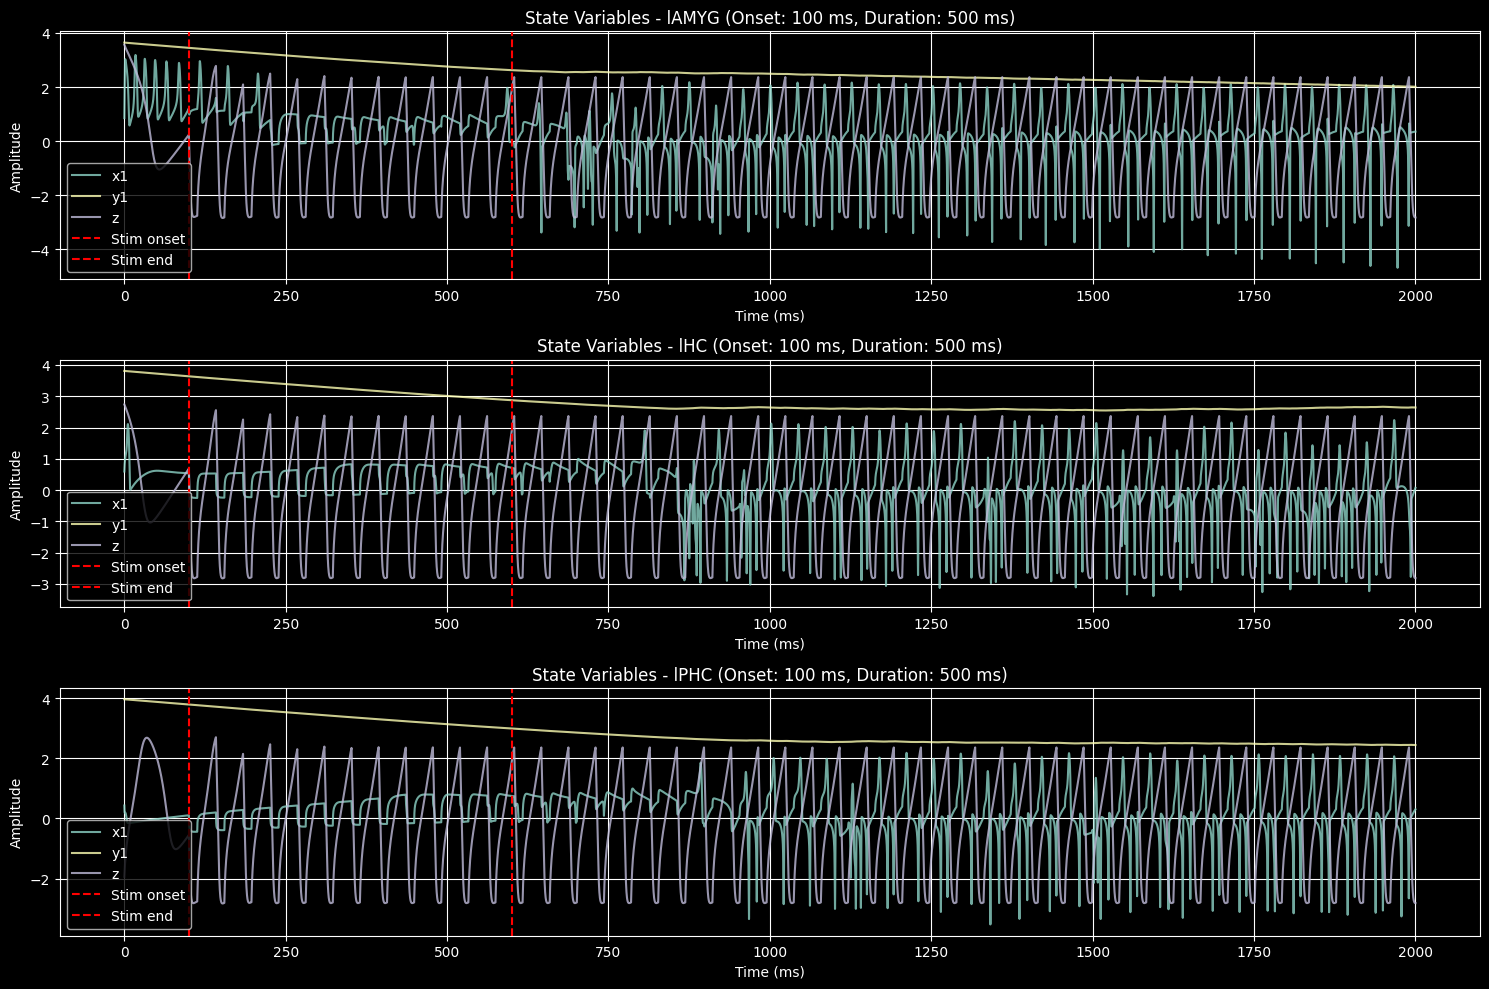

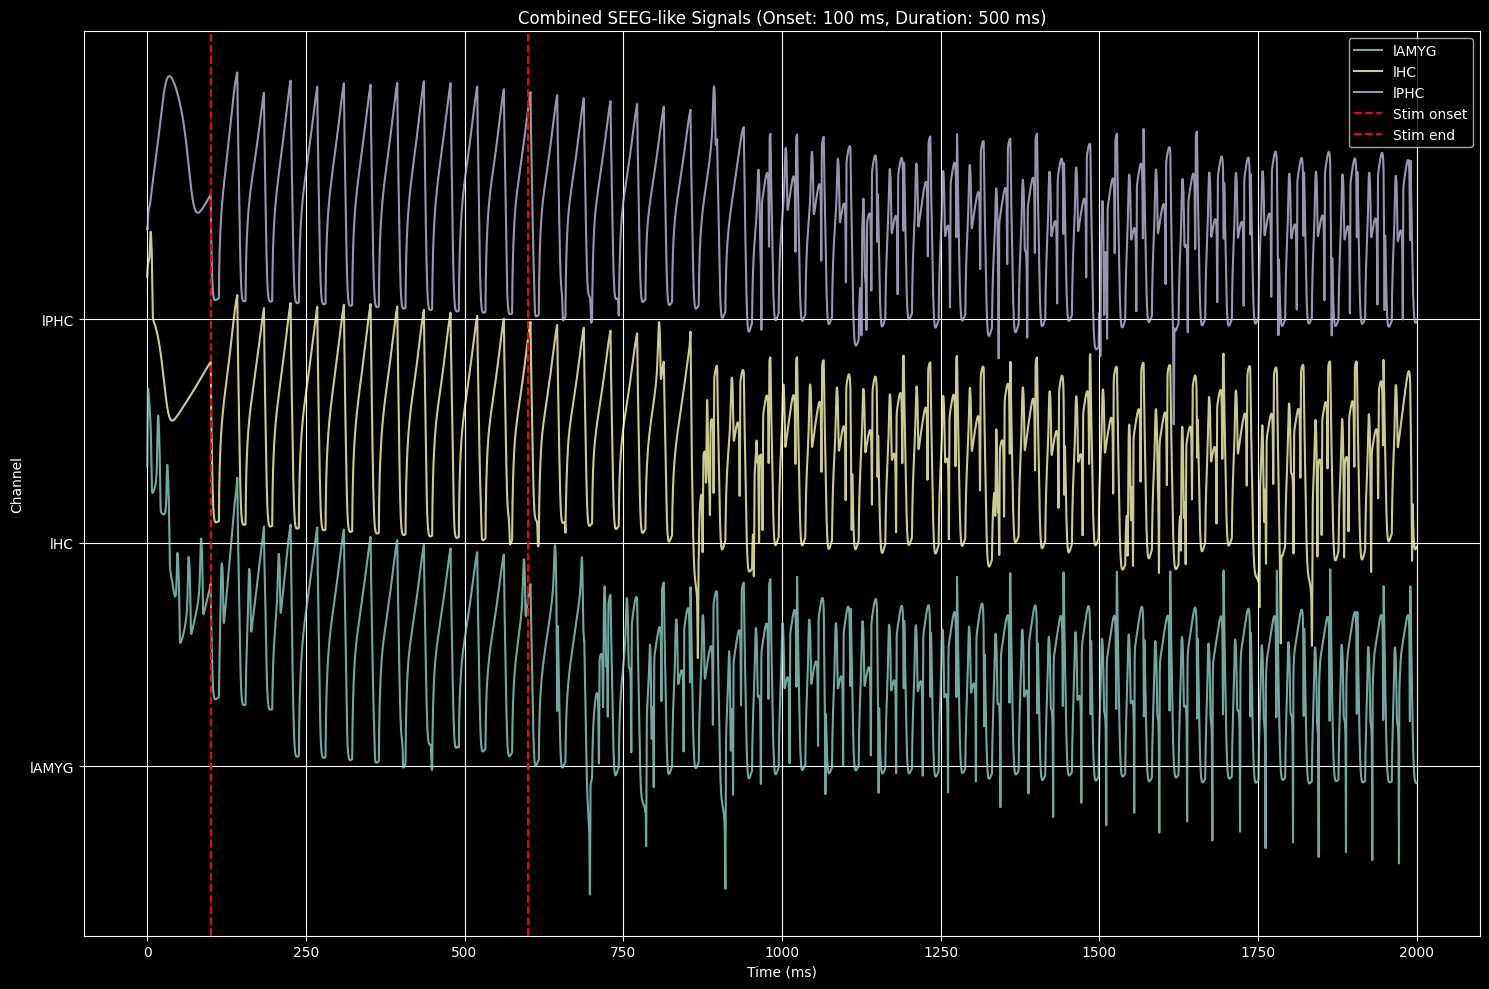

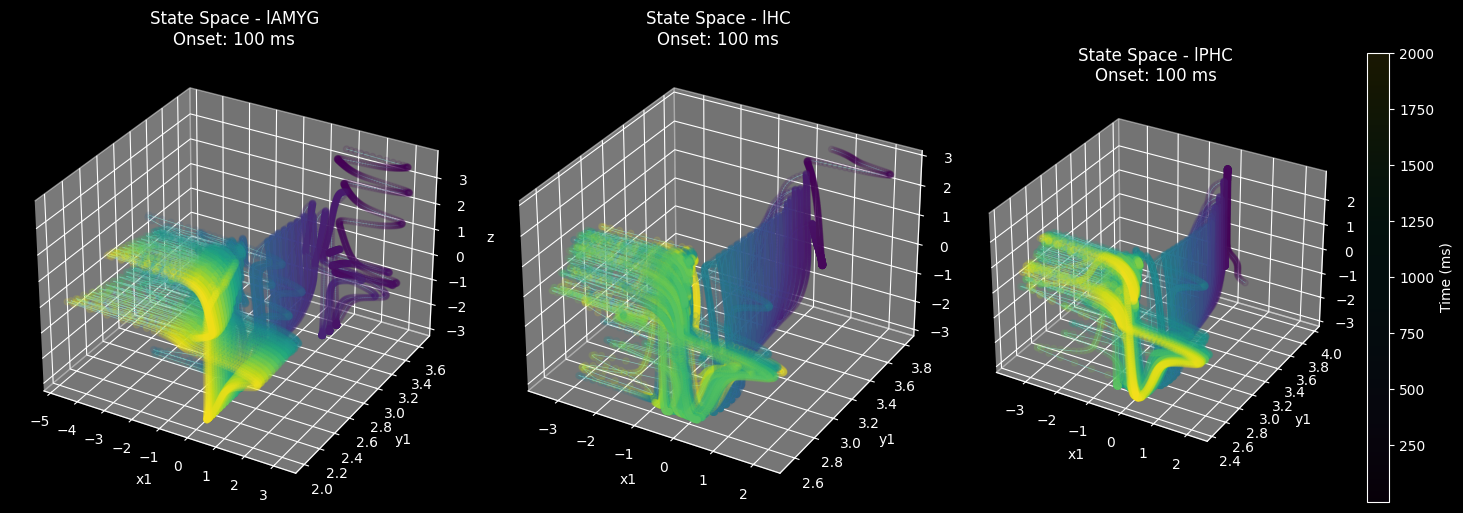

2024-10-26 14:52:21,890 - WARNING - tvb.simulator.integrators - random_state supplied for non-stochastic integration


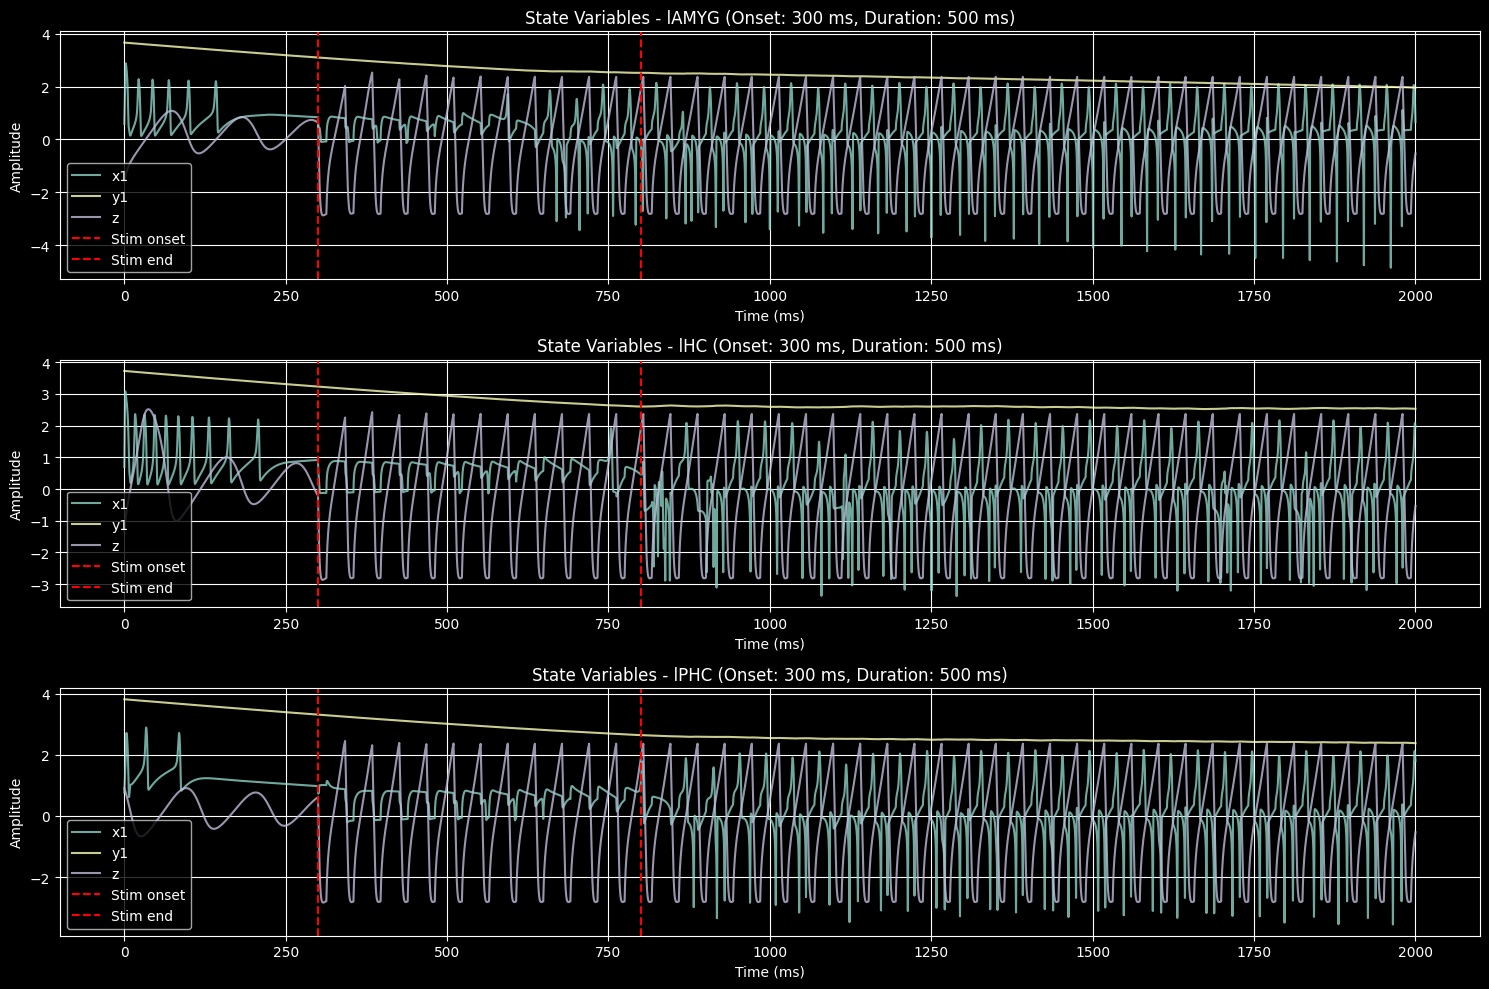

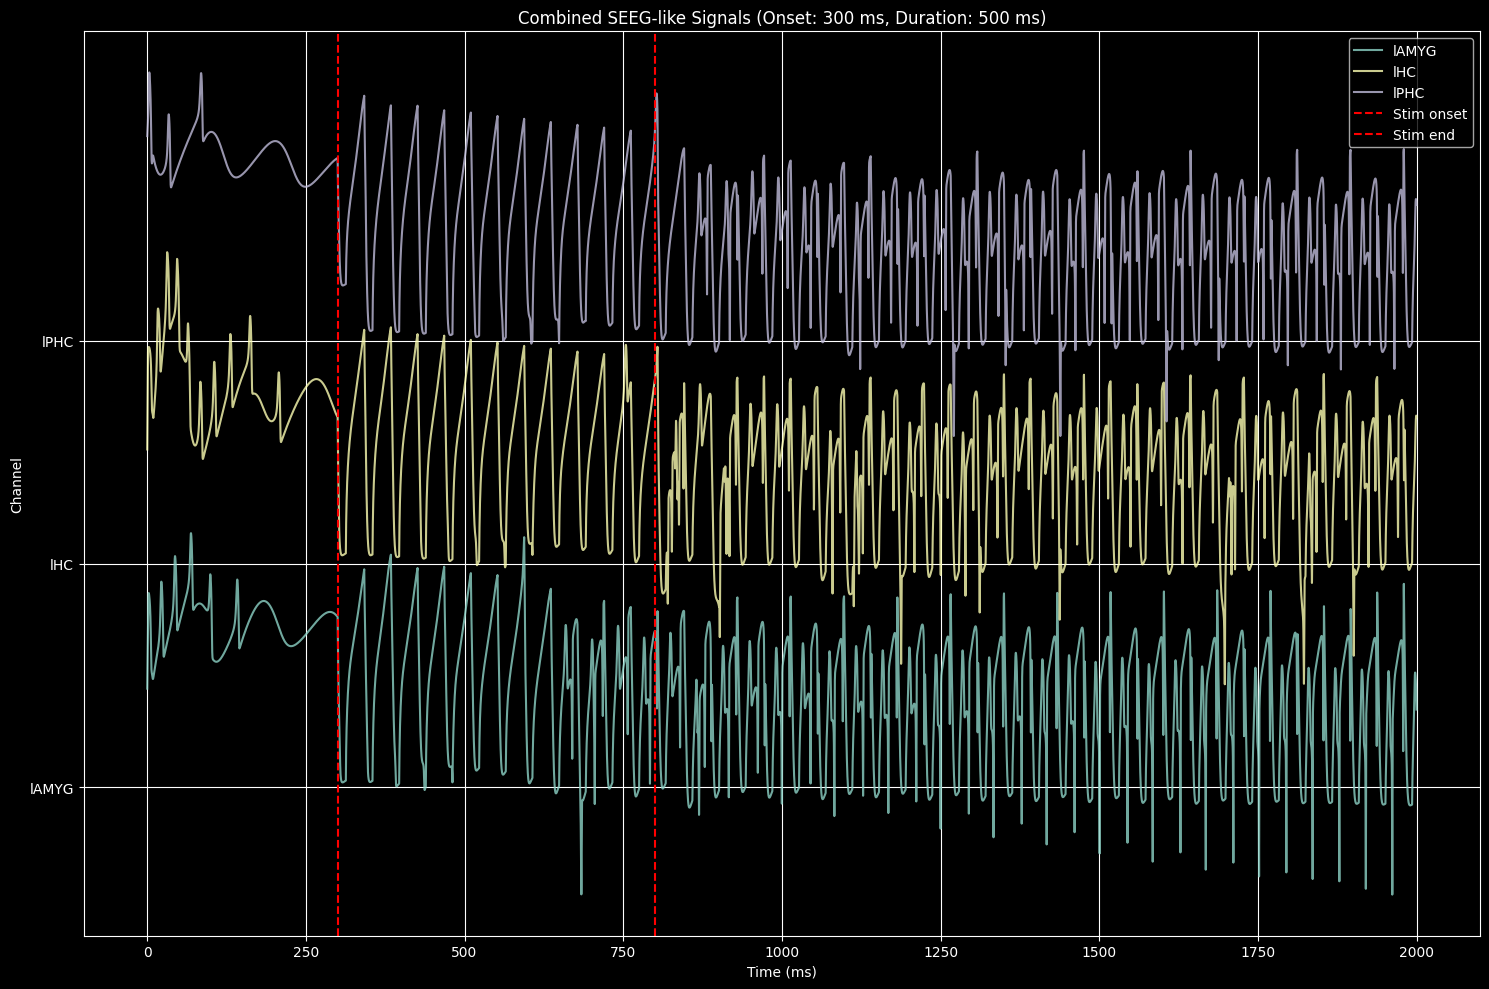

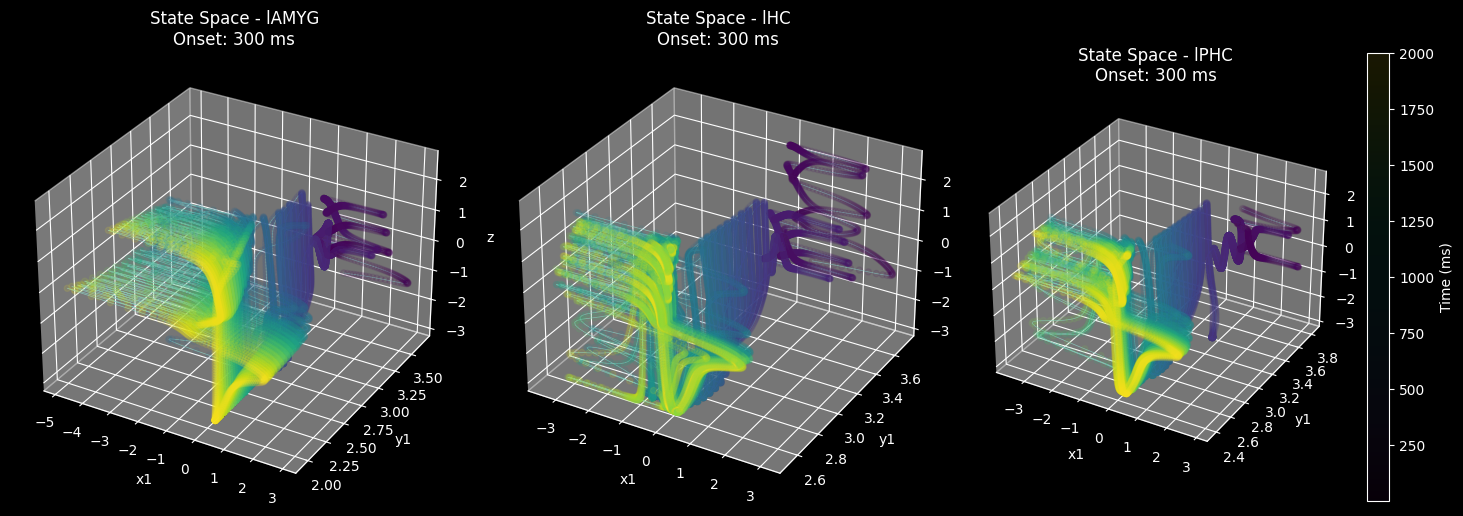

2024-10-26 14:52:26,239 - WARNING - tvb.simulator.integrators - random_state supplied for non-stochastic integration


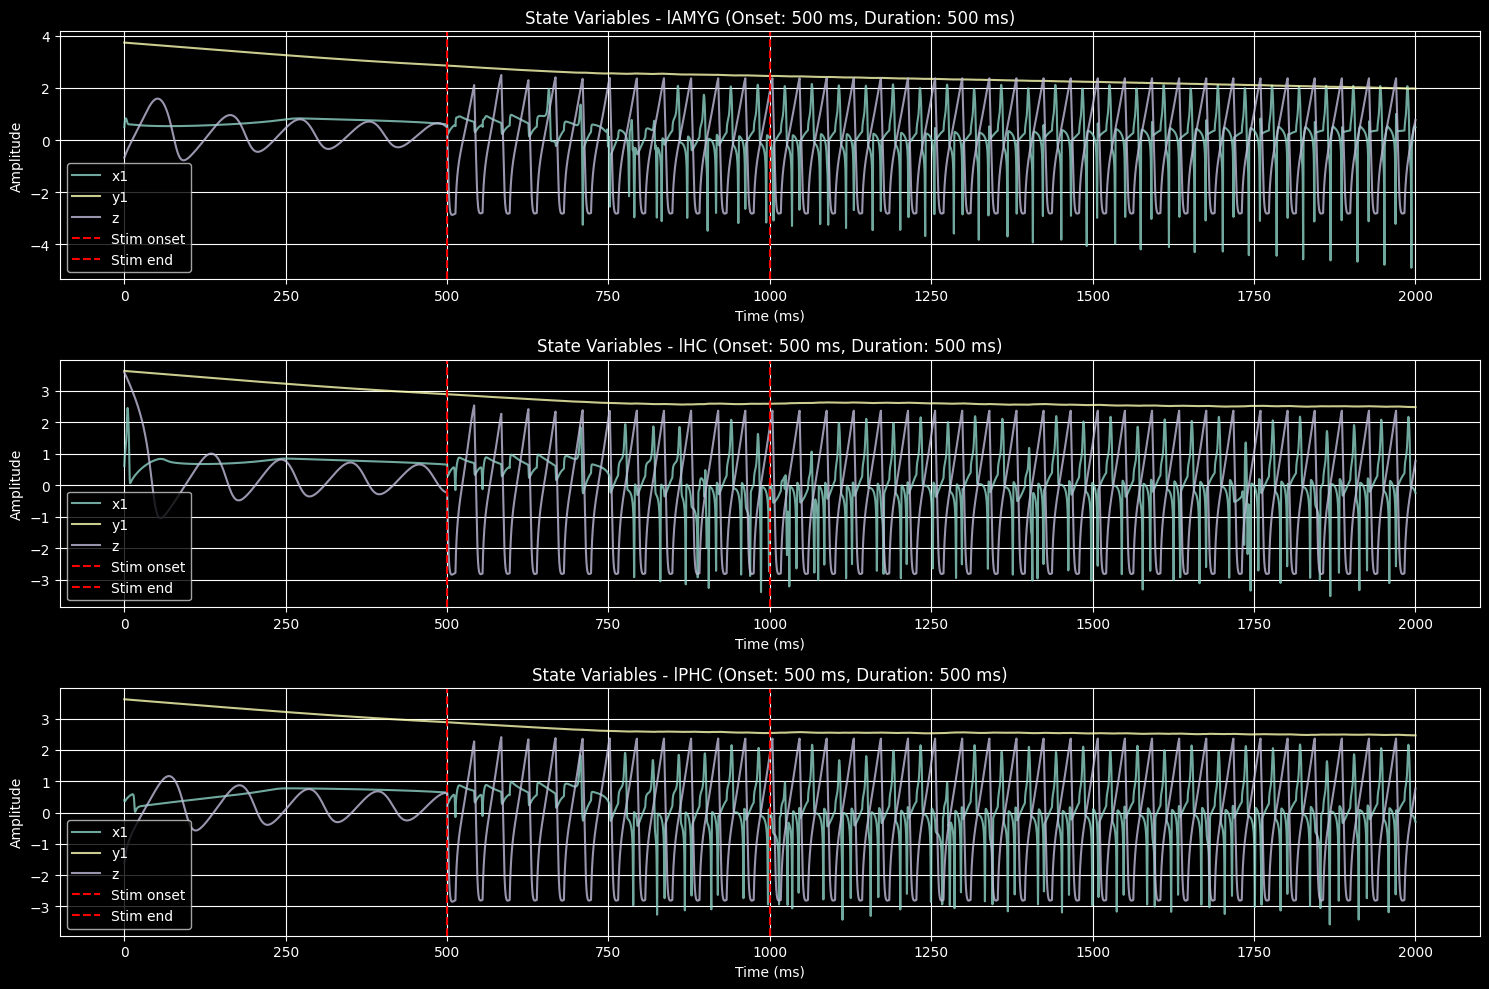

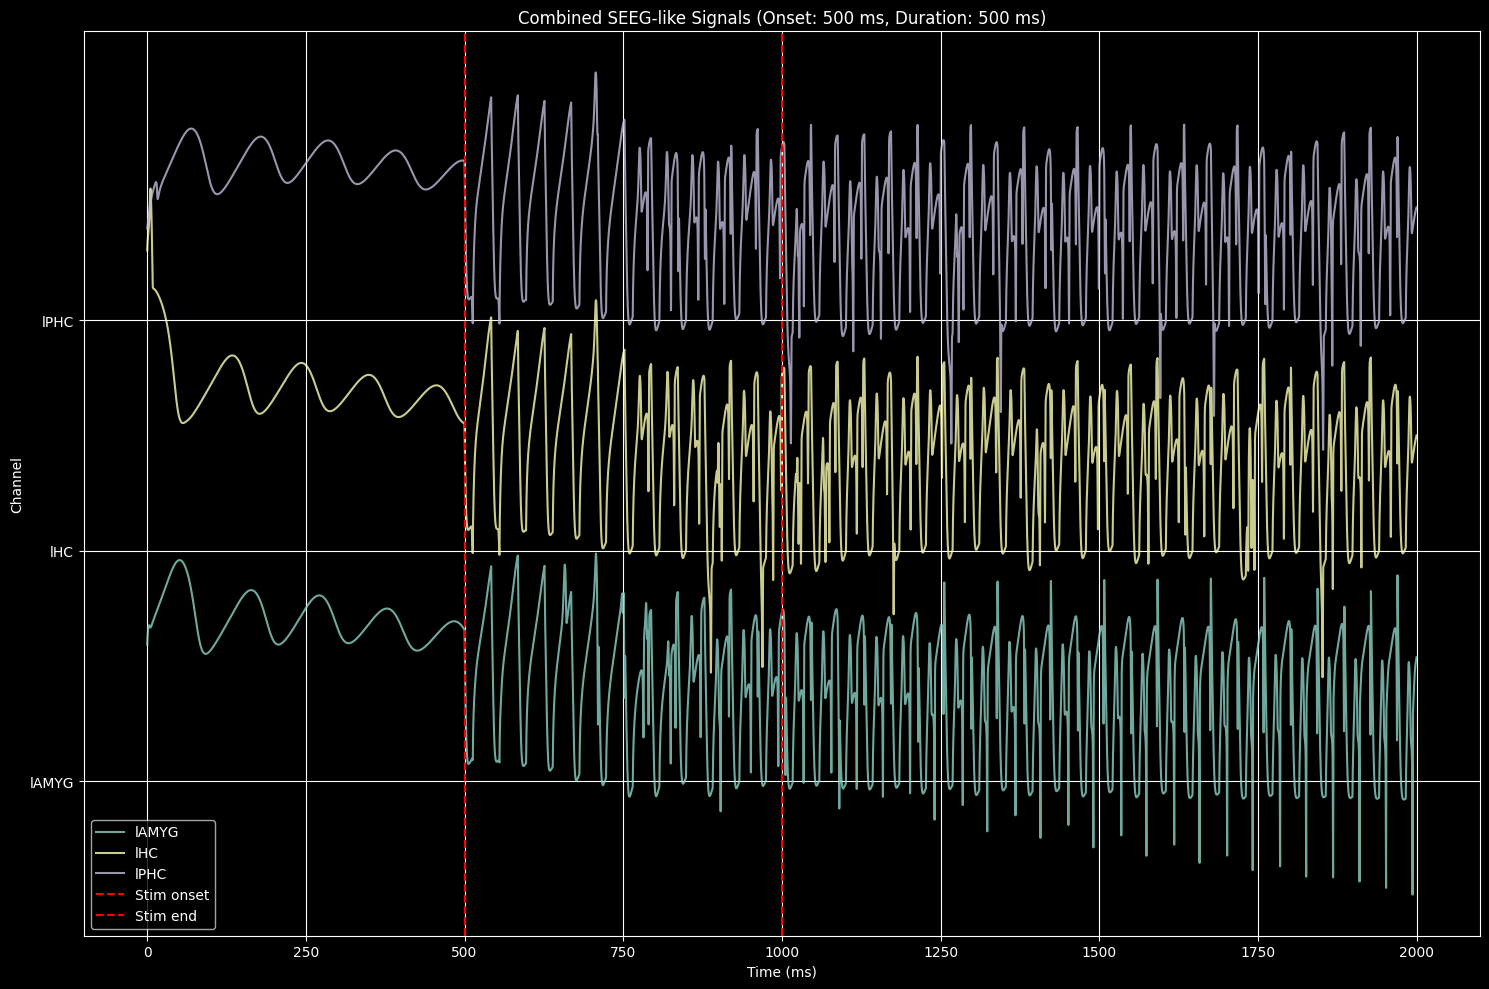

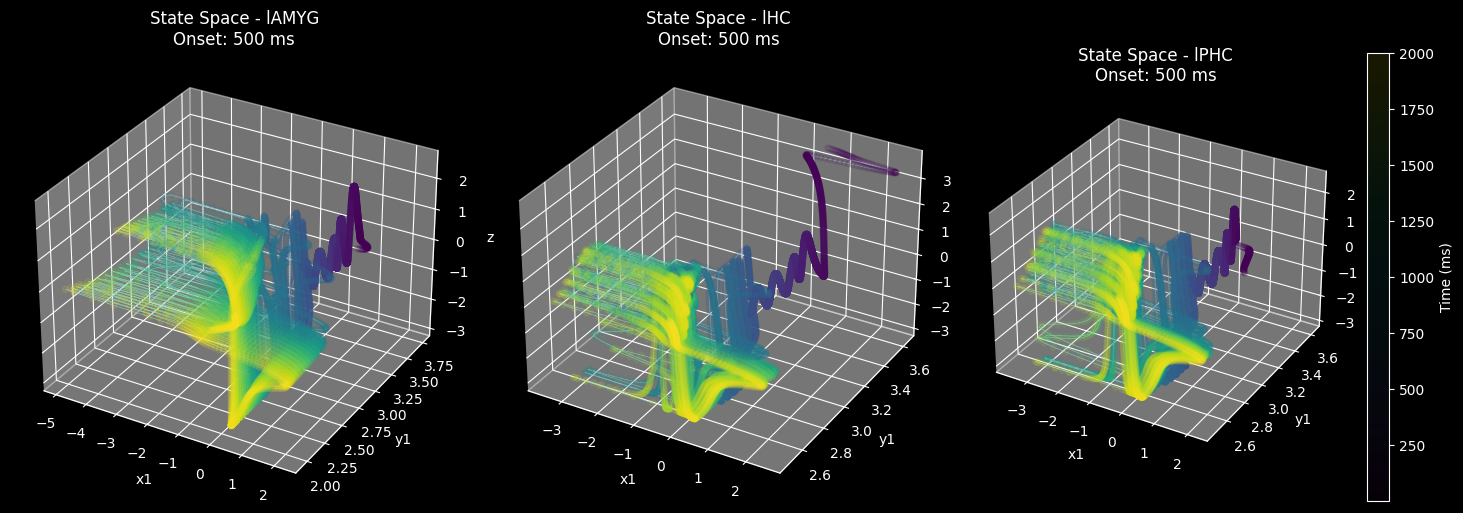

2024-10-26 14:52:30,042 - WARNING - tvb.simulator.integrators - random_state supplied for non-stochastic integration


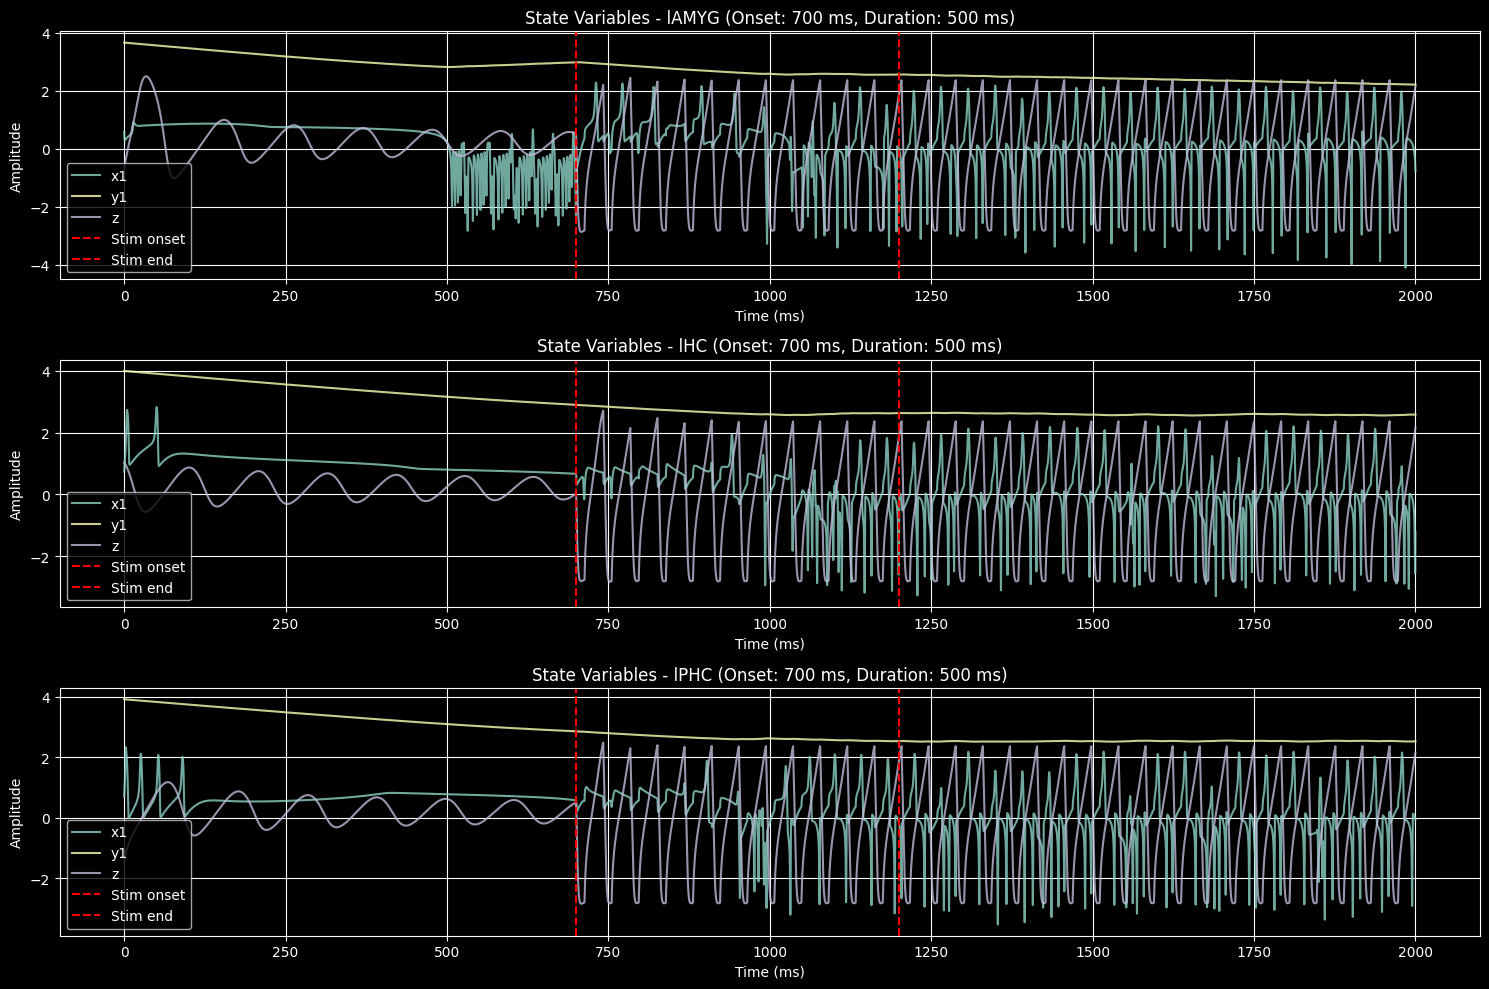

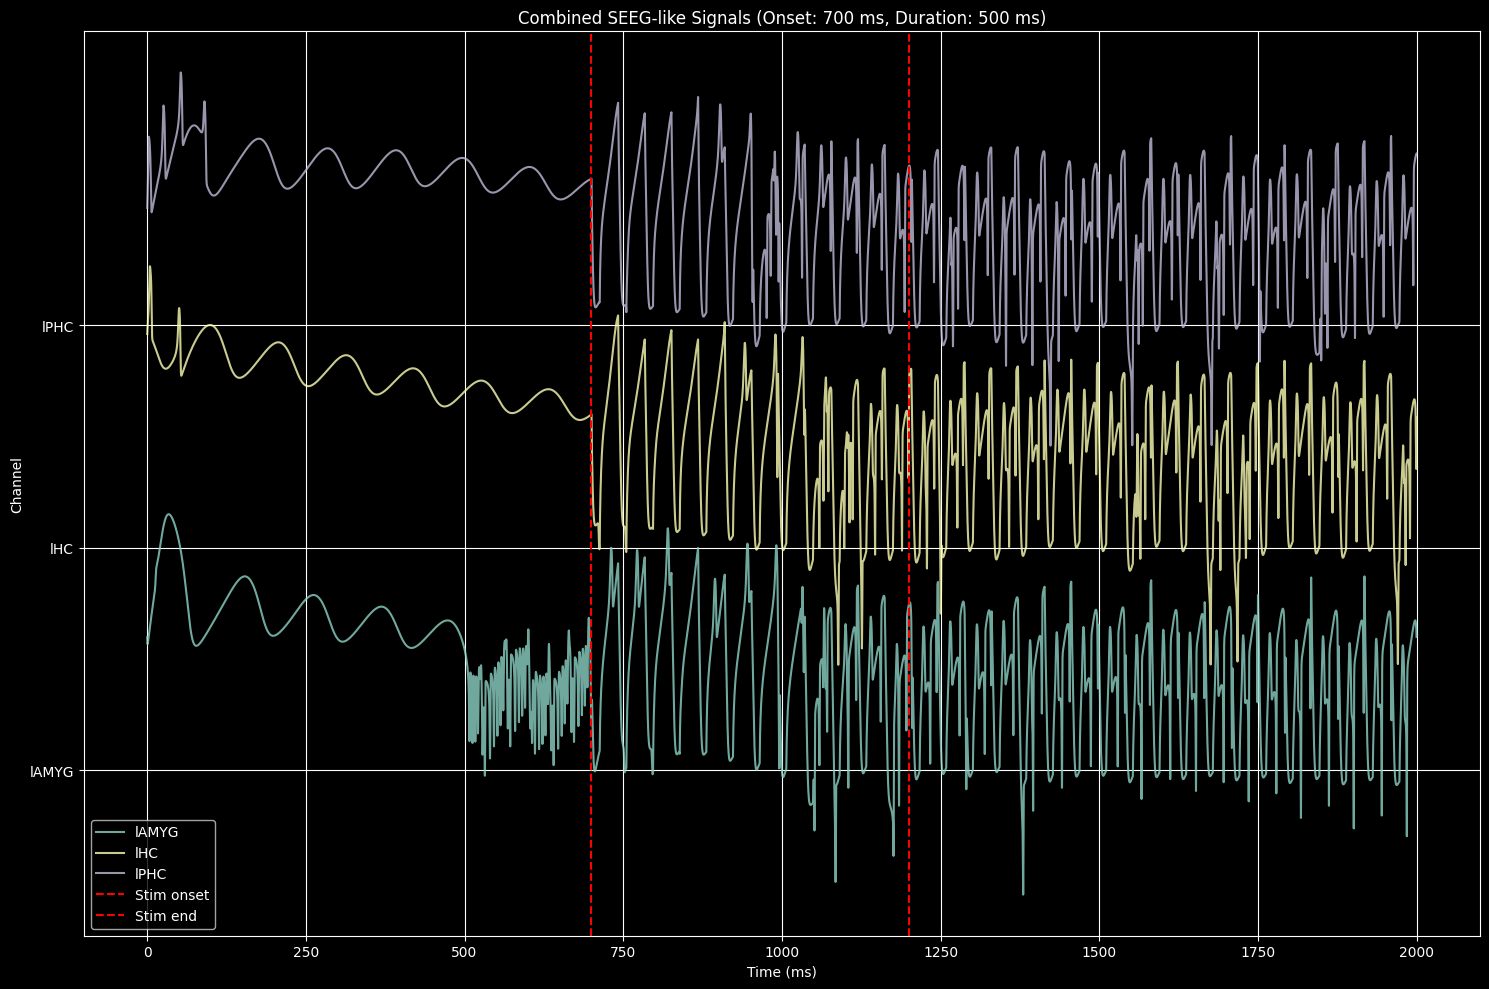

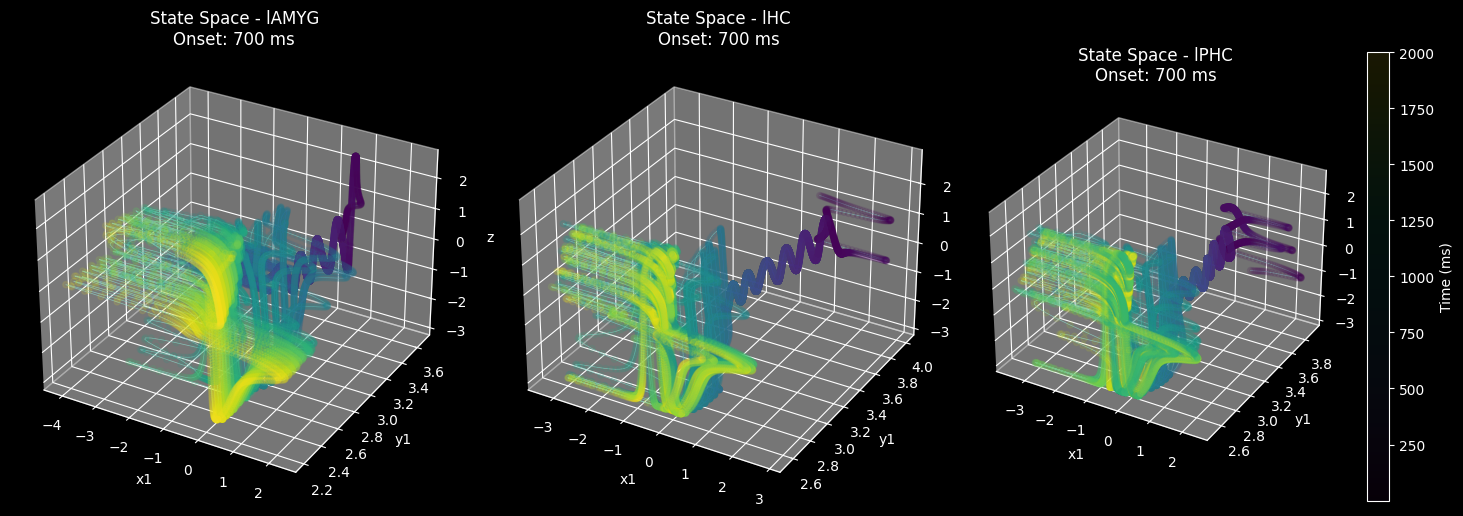

2024-10-26 14:52:34,302 - WARNING - tvb.simulator.integrators - random_state supplied for non-stochastic integration


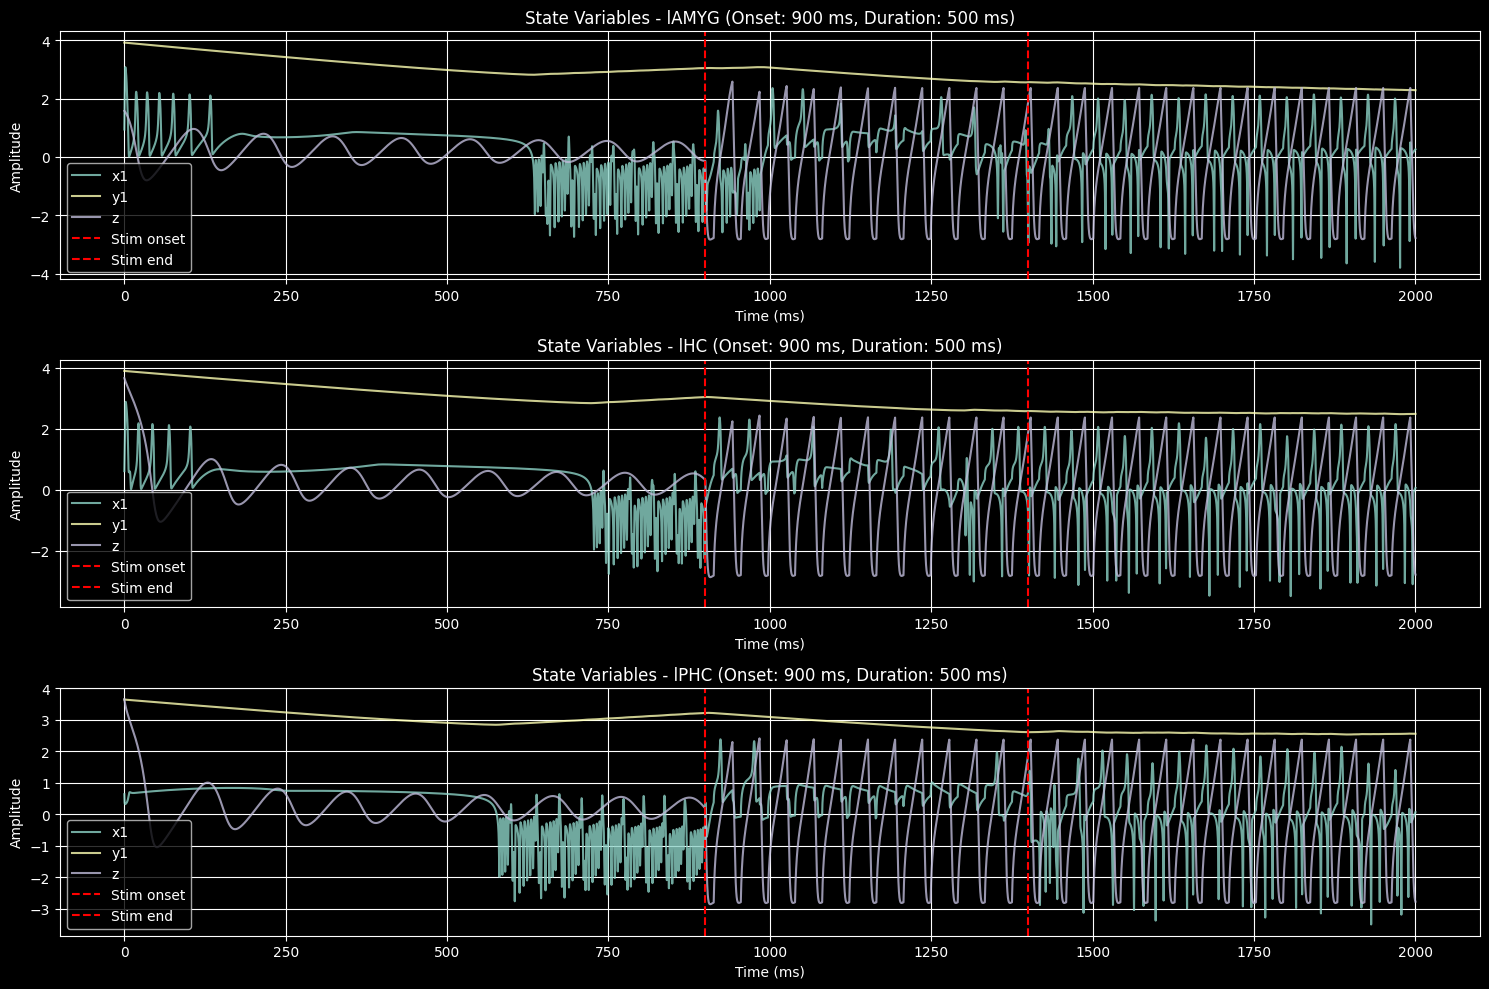

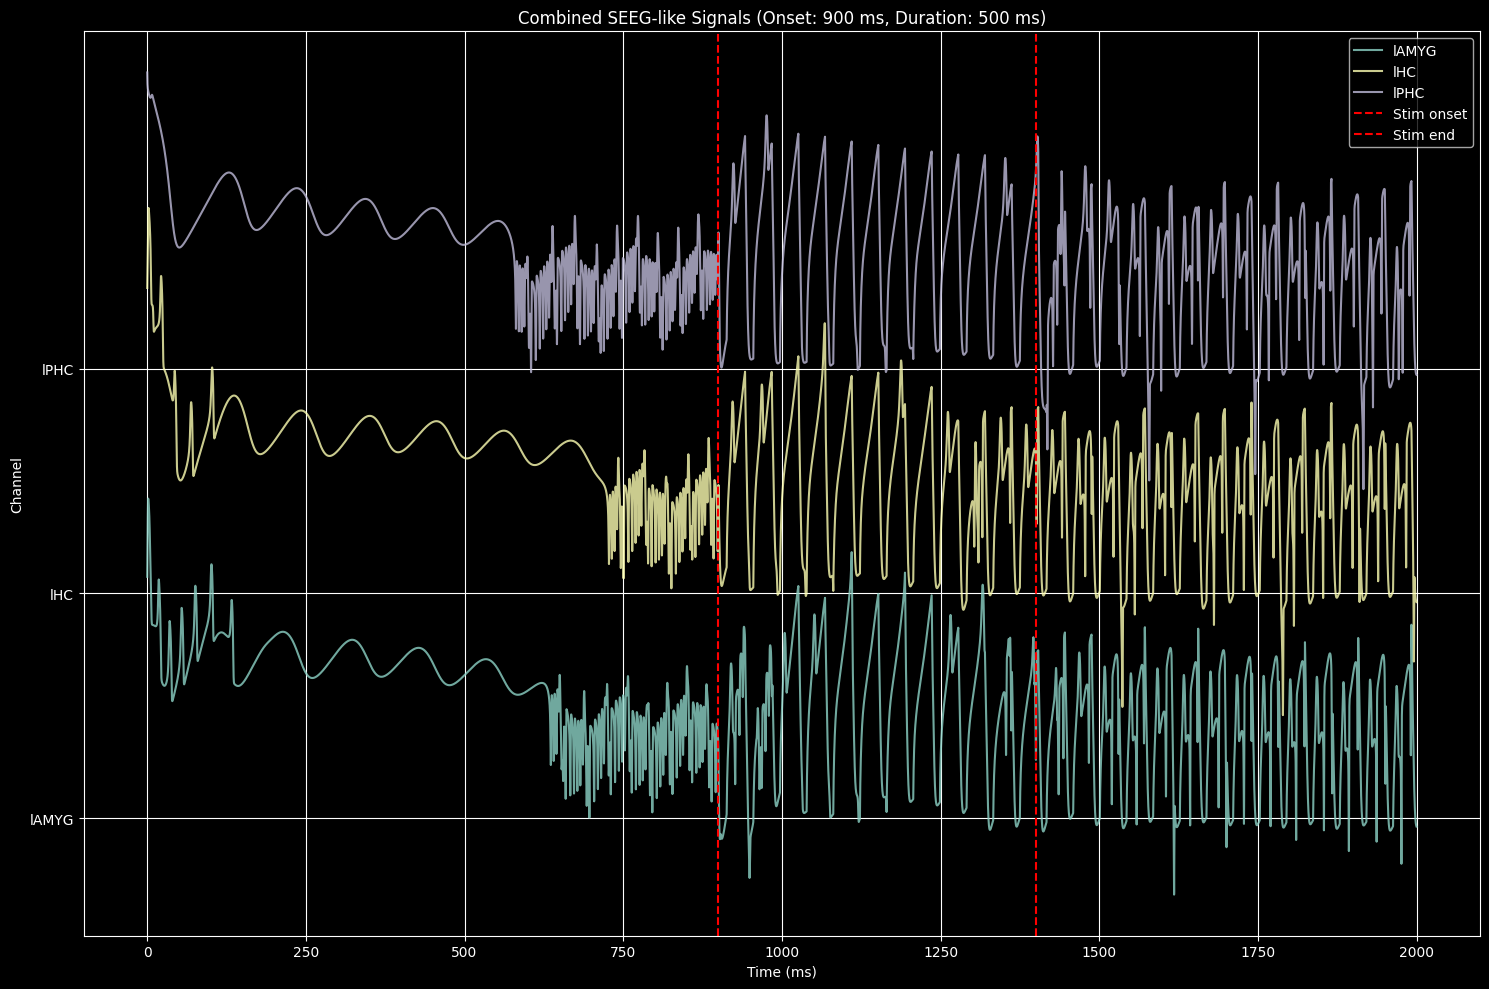

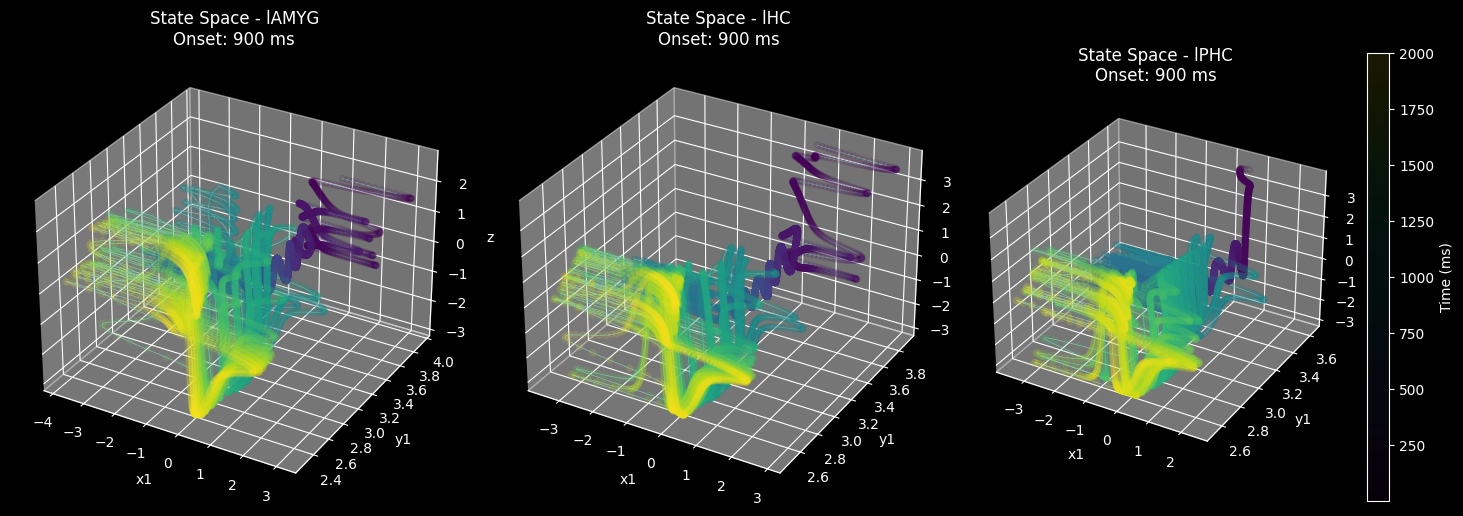

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tvb.simulator.lab import *

# Set a fixed random seed
np.random.seed(42)

# Load Structural Connectivity Matrix
con = connectivity.Connectivity.from_file()
nregions = len(con.region_labels)
con.weights = con.weights - con.weights * np.eye(nregions)
con.speed = np.array([3.0])

# Custom Epileptor class to target x1
class ModifiedEpileptorRestingState(models.EpileptorRestingState):
    def coupling_variables(self):
        return ["x1"]  # Only affect x1 state variable

    def update_state_variables(self, state_variables, coupling, stimulus):
        # Apply stimulus directly to x1
        state_variables[0] += stimulus  # x1 is the first state variable
        return super().update_state_variables(state_variables, coupling, stimulus)

# Epileptor Model Setup
mod = ModifiedEpileptorRestingState()
mod.a_rs = np.ones((nregions)) * 1.7402

# Initial conditions
mod.x0 = np.ones((nregions)) * -2.3  # NIZ
mod.x0[[40]] = -1.2  # EZ: lAMYG
mod.x0[[47, 62]] = -1.4  # EZ: lHC, lPHC

# Coupling Setup
coupl = coupling.Difference(a=np.array([0.00015]))

# No noise for clearer results
heunint = integrators.HeunDeterministic(dt=0.1)

# Define different onset times to test
onset_times = [100, 300, 500, 700, 900] #  100, 300, 500, 700, 900

for onset in onset_times:
    # Stimulus Setup: Strong negative pulses to suppress seizure
    eqn_t = equations.PulseTrain()
    eqn_t.parameters.update({
        'onset': onset,  # Varying onset time
        'midpoint': onset + 250,  # Midpoint of the sigmoid (half of 500ms)
        'sigma': 10,  # Steepness of the sigmoid
        'amp': -2.0  # Strong negative amplitude for suppression
    })

    # Create stimulus pattern targeting specific regions
    weight_pattern = np.zeros((nregions,))
    weight_pattern[[40, 47, 62]] = .5  # Target EZ regions
    stimulus = patterns.StimuliRegion(
        temporal=eqn_t,
        connectivity=con,
        weight=weight_pattern
    )

    # Configure stimulus
    stimulus.configure_space()
    stimulus.configure_time(np.arange(0., 2000, 0.1))

    # Monitor Setup
    mon = monitors.Raw()

    # Simulator Configuration
    sim = simulator.Simulator(
        model=mod,
        connectivity=con,
        coupling=coupl,
        integrator=heunint,
        monitors=[mon],
        stimulus=stimulus
    )
    sim.configure()

    # Run simulation
    sim.simulation_length = 2000.0
    (time, data), = sim.run()

    # Plot results
    regions = [40, 47, 62]  # lAMYG, lHC, lPHC
    labels = ['lAMYG', 'lHC', 'lPHC']

    # Plot state variables
    plt.figure(figsize=(15, 10))
    for idx, region in enumerate(regions):
        plt.subplot(3, 1, idx+1)
        plt.plot(time, data[:, 0, region, 0], label='x1', alpha=0.8)
        plt.plot(time, data[:, 1, region, 0], label='y1', alpha=0.8)
        plt.plot(time, data[:, 2, region, 0], label='z', alpha=0.8)
        
        plt.axvline(x=onset, color='r', linestyle='--', label='Stim onset')
        plt.axvline(x=onset+500, color='r', linestyle='--', label='Stim end')
        plt.title(f'State Variables - {labels[idx]} (Onset: {onset} ms, Duration: 500 ms)')
        plt.xlabel('Time (ms)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plot combined SEEG-like signals
    plt.figure(figsize=(15, 10))
    for idx, region in enumerate(regions):
        combined_signal = (data[:, 0, region, 0] + 
                          data[:, 1, region, 0] + 
                          data[:, 2, region, 0]) / 3.0
        
        plt.plot(time, combined_signal + idx*2, label=labels[idx], alpha=0.8)

    plt.axvline(x=onset, color='r', linestyle='--', label='Stim onset')
    plt.axvline(x=onset+500, color='r', linestyle='--', label='Stim end')
    plt.title(f'Combined SEEG-like Signals (Onset: {onset} ms, Duration: 500 ms)')
    plt.xlabel('Time (ms)')
    plt.ylabel('Channel')
    plt.yticks(np.arange(len(regions))*2, labels)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

        # Plot 3D state space trajectories
    fig = plt.figure(figsize=(15, 5))
    for idx, region in enumerate(regions):
        ax = fig.add_subplot(1, 3, idx+1, projection='3d')
        
        # Plot state variables (x1, y1, z)
        ax.plot(data[:, 0, region, 0],  # x1
                data[:, 1, region, 0],  # y1
                data[:, 2, region, 0],  # z
                lw=0.5, alpha=0.8)
        
        # Color coding for time
        scatter = ax.scatter(data[:, 0, region, 0],
                            data[:, 1, region, 0],
                            data[:, 2, region, 0],
                            c=time, cmap='viridis', alpha=0.1)
        
        ax.set_xlabel('x1')
        ax.set_ylabel('y1')
        ax.set_zlabel('z')
        ax.set_title(f'State Space - {labels[idx]}\nOnset: {onset} ms')

    plt.colorbar(scatter, label='Time (ms)')
    plt.tight_layout()
    plt.show()